Structured Learning:
=====================
In this exercise we will implement a structured learning system for
foreground background segmentation.
We will learn the weights of a CRF Potts model.


The first step is to  import all needed modules

In [1]:
# misc
import numpy
import sys

# visualization
import matplotlib.pyplot as plt
import pylab

# features
import skimage.filters

# discrete graphical model package
from dgm.models import *
from dgm.solvers import *
from dgm.value_tables import *
# misc. tools
from tools import make_toy_dataset, norm01

import matplotlib.pyplot as plt

from tools import make_toy_dataset, norm01

The Dataset
===============

Here we use a toy dataset where we have white squares on black background
with some noise.
The noise level is given by the variable ``noise``.


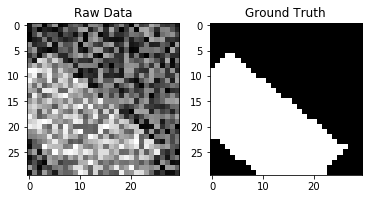

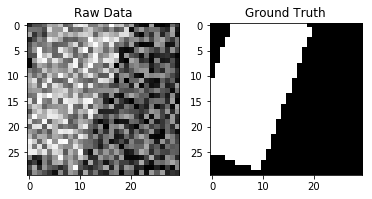

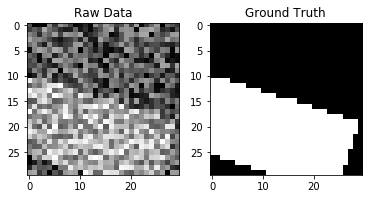

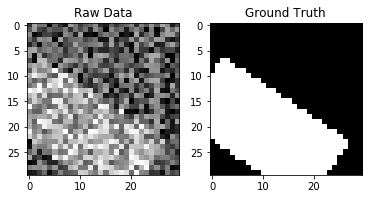

In [16]:
noise = 2.0
shape = (30,30)



x_train, y_train =  make_toy_dataset(shape=shape, n_images=5, noise=noise)
x_test , y_test  =  make_toy_dataset(shape=shape, n_images=5, noise=noise)

# show a bit from the dataset
for x in range(4):
    f= pylab.figure()
    ax1 = f.add_subplot(1,2,1)
    pylab.imshow(x_train[x],cmap='gray')
    ax1.set_title('Raw Data')

    ax2 = f.add_subplot(1,2,2)
    pylab.imshow(y_train[x],cmap='gray')
    ax2.set_title('Ground Truth')
    plt.show()

The Unary  Features (5Pt):
==============

Here you need to implement a function which should return 
pixel wise unary features.
You can use features like gaussian smooting with differnet 
sigmas.
About 5 features should be enough.

The features should be normalized to be in [0,1]



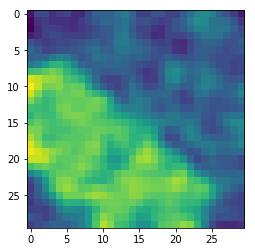

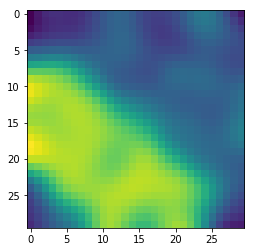

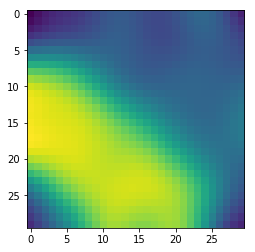

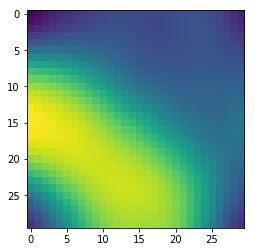

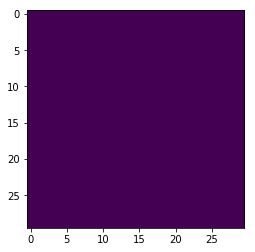

In [17]:
from skimage.morphology import disk

def getNormalizedPicture(raw):
    m = 1 / (numpy.max(raw) - numpy.min(raw))
    d = -1 * numpy.min(raw) / (numpy.max(raw) - numpy.min(raw))
    normalizedRaw = raw * m + d
    return normalizedRaw

def get_unary_features(raw):
    features = []
    
    ############################################
    # ADD YOUR CODE HERE
    ############################################
    for i in range(1,5):
        normalizedRaw = getNormalizedPicture(raw)
        features.append(skimage.filters.gaussian(normalizedRaw,i)[:,:,None])
    
    
    features.append(numpy.ones(raw.shape)[:,:,None])
    return  numpy.concatenate(features, axis=2)
    


# visualize the features for a raw image
unary_features = get_unary_features(x_train[0])
n_unary_features = unary_features.shape[2]
for i in range(unary_features.shape[2]):
    pylab.imshow(unary_features[:,:,i])
    pylab.show()

The Potts Features (5 P):
==========
Here youn need to implement a function returing pixel
wise features which are used within the potts term.
The features should be something like edge detectors.

$e^{-1.0\cdot|\text{edge_strength}|} $ should work well.

You can compute edge filters on different sigmas by presmoothing the 
raw data with a gaussian.
About five features should be enough.

The features should be normalized to be in [0,1]


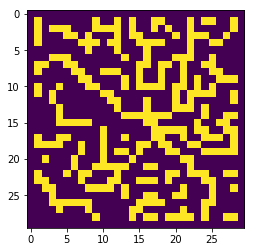

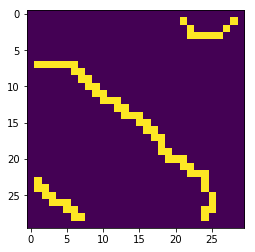

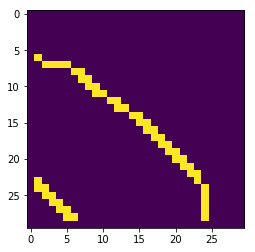

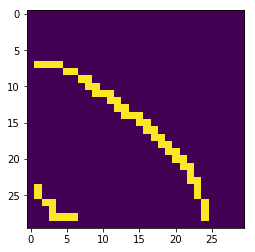

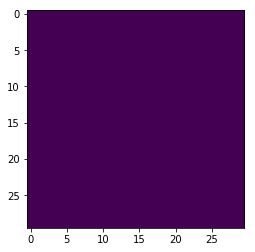

In [28]:
from skimage import feature as skFeature

def get_potts_features(raw):
    features = []    
    
    ############################################
    # ADD YOUR CODE HERE
    ############################################
    for i in range(1,5):
        normalizedRaw = getNormalizedPicture(raw)
        expImage = skFeature.canny(normalizedRaw, i)[:,:,None] 
        # expImage = numpy.exp(skFeature.canny(normalizedRaw, i)[:,:,None])
        features.append(expImage)
    
    
    # a constant feature is needed 
    features.append(numpy.ones(raw.shape)[:,:,None])
    return  numpy.concatenate(features, axis=2)


# visualize the features for a raw image
potts_features = get_potts_features(x_train[0])
n_potts_features = potts_features.shape[2]
for i in range(potts_features.shape[2]):
    pylab.imshow(potts_features[:,:,i])
    pylab.show()

Loss Function:
==========

In  this example we will use a very simple ``Hamming Loss``.

In [19]:
class HammingLoss(object):
    def __init__(self, y_true):
        self.y_true = y_true.copy()
    
    def __call__(self, y_pred):
        """total loss"""
        return numpy.sum(self.y_true!=y_pred)
    

Function to set up the weighted Model:
======================
This function will set up the weighted graphical model
and also the loss augmented


Model: $$\textbf{argmin}_{y} \quad w \cdot \phi(x,y) $$
Loss Augmented Model: $$\textbf{argmin}_{y} \quad w \cdot \phi(x,y)  - \Delta(\hat{y},y)$$

In [46]:
def build_model(raw_data, gt_image, weights): 
    shape = raw_data.shape
    n_var = shape[0] * shape[1]
    n_labels = 2 
    variable_space = numpy.ones(n_var)*n_labels


    # lets compute some filters for the uanry features
    unary_features = get_unary_features(raw_data)
    
    # lets compute some filters for the potts features
    potts_features = get_potts_features(raw_data)

    n_weights =potts_features.shape[2] + unary_features.shape[2]
    
    #print("n_weights",n_weights)
    assert n_weights == len(weights)


    # both graphical models
    gm = WeightedDiscreteGraphicalModel(variable_space=variable_space, weights=weights)
    loss_augmented_gm = WeightedDiscreteGraphicalModel(variable_space=variable_space, weights=weights)
    
    # convert coordinates to scalar
    def vi(x0,x1):
        return x1 + x0*shape[1]





    # weight ids for the unaries
    # (just plain numbers to remeber which weights
    # are associated with the unary features)
    weight_ids = numpy.arange(unary_features.shape[2])
    for x0 in range(shape[0]):
        for x1 in range(shape[1]):

            pixel_val = raw_data[x0, x1]
            gt_label = gt_image[x0, x1]
            features = unary_features[x0, x1, :]

            unary_function = WeightedTwoClassUnary(features=features, weight_ids=weight_ids, 
                                                 weights=weights)

            if gt_label == 0:
                loss = numpy.array([0,1])
            else:
                loss = numpy.array([1,0])

            loss_augmented_unary_function = WeightedTwoClassUnary(features=features, weight_ids=weight_ids, 
                                                   weights=weights, const_terms=-1.0*loss)

            variables = vi(x0,x1)
            gm.add_factor(variables=variables, value_table=unary_function)
            loss_augmented_gm.add_factor(variables=variables, value_table=loss_augmented_unary_function)

    # add pairwise factors
    # the weight id's for the pairwise factors
        
    # average over 2 coordinates to extract
    # extract feature vectors for potts functins
    def get_potts_feature_vec(coord_a, coord_b):
        
        fa = potts_features[coord_a[0],coord_a[1],:]
        fb = potts_features[coord_b[0],coord_b[1],:]
        return (fa+fb)/2.0

    # weight ids for the potts functions
    # (just plain numbers to remeber which weights
    # are associated with the potts features)
    weight_ids = numpy.arange(potts_features.shape[2]) + unary_features.shape[2]

    for x0 in range(shape[0]):
        for x1 in range(shape[1]):

            # horizontal edge
            if x0 + 1 < shape[0]:
                variables = [vi(x0,x1),vi(x0+1,x1)]
                features = get_potts_feature_vec((x0,x1), (x0+1,x1))
                # the weighted potts function
                potts_function = WeightedPottsFunction(shape=[2,2],
                                                       features=features, 
                                                       weight_ids=weight_ids, 
                                                       weights=weights)
                # add factors to both models
                gm.add_factor(variables=variables, value_table=potts_function)
                loss_augmented_gm.add_factor(variables=variables, value_table=potts_function)

            # vertical edge
            if x1 + 1 < shape[1]:
                variables = [vi(x0,x1),vi(x0, x1+1)]
                features = get_potts_feature_vec((x0,x1), (x0,x1+1))
                # the weighted potts function
                potts_function = WeightedPottsFunction(shape=[2,2],
                                                       features=features, 
                                                       weight_ids=weight_ids,
                                                       weights=weights)
                # add factors to both models
                gm.add_factor(variables=variables, value_table=potts_function)
                loss_augmented_gm.add_factor(variables=variables, value_table=potts_function)
        
    # gm, loss augmented and the loss
    return gm,loss_augmented_gm, HammingLoss(gt_image.ravel())

Build the weighted models:
===============

In [47]:
#
n_weights = n_unary_features + n_potts_features
weights = numpy.zeros(n_weights)

 # build the graphical models
models_train  = [build_model(x,y, weights) for x,y in zip(x_train, y_train)]
models_test   = [build_model(x,y, weights) for x,y in zip(x_test, y_test)]


# very simple helper class to combine things
class Dataset(object):
    def __init__(self, models_train, models_test, weights):
        self.models_train = models_train
        self.models_test = models_test
        self.weights = weights
dset = Dataset(models_train, models_test, weights)



Subgradient SSVM
=========================

Instead of a cutting plane approach, we use a subgradient decent to
find the optimal weights

[Learn more about subgradient ssvm](https://www.google.de/url?sa=t&rct=j&q=&esrc=s&source=web&cd=3&cad=rja&uact=8&ved=0ahUKEwjkwJrWuPvTAhWLbVAKHWx-DQoQFgg3MAI&url=http%3A%2F%2Fwww.nowozin.net%2Fsebastian%2Fcvpr2011tutorial%2Fslides%2Ftalk-ssvm.pdf&usg=AFQjCNH6ZetauyPusXpNBWxdmZshHujgmw&sig2=q1tJ-0DgX9WuGuDIK8-eJw)

In [48]:
def subgradient_ssvm(dataset, n_iter=20, learning_rate=1.0, c=0.5, lower_bounds=None, upper_bounds=None, convergence=0.001):
    
    weights = dataset.weights
    n = len(dataset.models_train)
    
    if lower_bounds is None:
        lower_bounds = numpy.ones(len(weights))*-1.0*float('inf')

    if upper_bounds is None:
        upper_bounds = numpy.ones(len(weights))*float('inf')
    
    do_opt = True
    for iteration in range(n_iter): 

        effective_learning_rate = learning_rate*float(learning_rate)/(1.0+iteration)
        
        # compute gradient
        diff = numpy.zeros(weights.shape)
        for gm, gm_loss_augmented, loss_function in dataset.models_train:

            # update the weights to the current weight vector
            gm.change_weights(weights)
            gm_loss_augmented.change_weights(weights)

            # the gt vector
            y_true = loss_function.y_true



            # optimize loss augmented /
            # find most violated constraint
            graphcut = GraphCut(model=gm_loss_augmented)
            y_hat = graphcut.optimize()

            # compute joint feature vector
            phi_y_hat  = gm.phi(y_hat)
            phi_y_true = gm.phi(y_true)

            diff +=  phi_y_true - phi_y_hat
    
        

        new_weights = weights - effective_learning_rate*(c/n)*diff

        # project new weights 
        where_to_large = numpy.where(new_weights>upper_bounds)
        new_weights[where_to_large]  = upper_bounds[where_to_large]
        where_to_small = numpy.where(new_weights<lower_bounds)
        new_weights[where_to_small]  = lower_bounds[where_to_small]


        delta = numpy.abs(new_weights-weights).sum()
        if(delta<convergence):
            print("converged")
            break
        print('iter',iteration, 'delta',delta,"  ",numpy.round(new_weights,3))

        weights = new_weights
    

    return weights

Learn The Weights:
==========================

We call use graphcut to find the argmin of the gm and
the loss augmented gm.
Graphcut will find optimal values iff the potts regularizer is 
positive.
To ensure a positive regularizer is learned, we 
can constraint the weights of the potts function to be positive. 


In [50]:

lower_bounds = numpy.ones(len(weights))*(-1.0*float('inf'))

# we want the regularizer 'beta' to be positive
lower_bounds[n_unary_features:n_unary_features+n_potts_features] = 0
    
weights = subgradient_ssvm(dset,c=0.5,learning_rate=1.0, lower_bounds=lower_bounds, n_iter=100)


iter 0 delta 172.603159967    [-35.46  -29.397 -23.898 -18.648  65.2     0.      0.      0.      0.      0.   ]
iter 1 delta 103.143795314    [-53.632 -46.928 -40.991 -35.396  34.25    0.      0.      0.      0.
   2.65 ]
iter 2 delta 213.138471765    [ -23.704  -16.084   -9.393   -3.145  120.117    0.       0.       0.       0.
    0.   ]
iter 3 delta 168.417143815    [-55.015 -46.566 -39.065 -31.995  72.017   0.      0.      0.      0.      0.   ]
iter 4 delta 23.4800509452    [-51.395 -42.796 -35.234 -28.137  80.157   0.      0.      0.      0.
   0.26 ]
iter 5 delta 1.93122299766    [-51.658 -43.054 -35.499 -28.406  79.54    0.      0.      0.      0.      0.   ]
iter 6 delta 0.140975790435    [ -5.16330000e+01  -4.30290000e+01  -3.54830000e+01  -2.83950000e+01
   7.94970000e+01   0.00000000e+00   0.00000000e+00   2.10000000e-02
   0.00000000e+00   0.00000000e+00]
iter 7 delta 0.123353816631    [ -5.16110000e+01  -4.30080000e+01  -3.54680000e+01  -2.83850000e+01
   7.94600000e+01  

Training Set Performance:
===============

learnedn weights [-51.1479782  -42.56574443 -35.17912545 -28.18459342  78.75221055   0.           0.
   0.10223874   0.           0.        ]


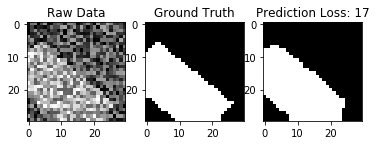

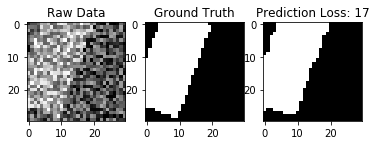

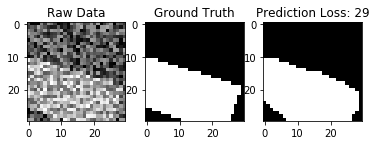

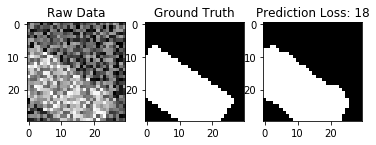

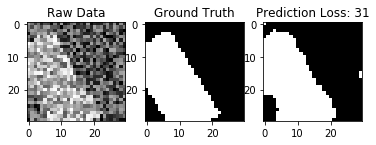

In [54]:
print("learnedn weights",weights)
for i,(gm,_,loss_function) in enumerate(models_train):
    gm.change_weights(weights)
    
    
    graphcut = GraphCut(model=gm)
    y_pred = graphcut.optimize()
    
    prediction_image = y_pred.reshape(shape)
    
    # show a bit from the dataset
   
    f= pylab.figure()
    ax1 = f.add_subplot(1,3,1)
    pylab.imshow(x_train[i],cmap='gray')
    ax1.set_title('Raw Data')
    
    ax2 = f.add_subplot(1,3,2)
    pylab.imshow(y_train[i],cmap='gray')
    ax2.set_title('Ground Truth')
    
    lossValue = loss_function(prediction_image.ravel())
 
    ax3 = f.add_subplot(1,3,3)
    pylab.imshow(prediction_image,cmap='gray')
    ax3.set_title('Prediction Loss: ' + str(lossValue))
    
    plt.show()


    
            

Test set performance:
==============

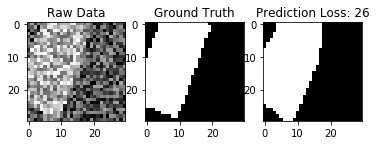

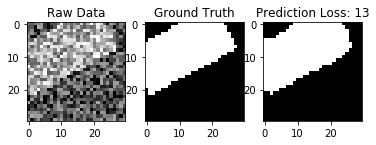

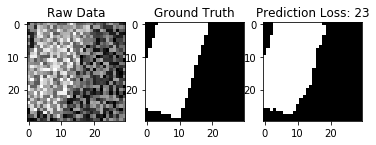

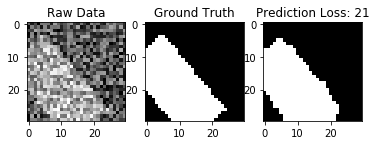

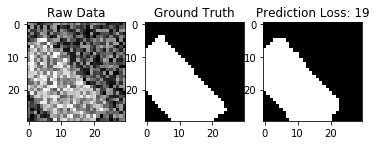

In [55]:
for i,(gm,_,loss_function) in enumerate(models_test):
    gm.change_weights(weights)
    
 
    graphcut = GraphCut(model=gm)
    y_pred = graphcut.optimize()
    
    prediction_image = y_pred.reshape(shape)
    
    # show a bit from the dataset
   
    f= pylab.figure()
    ax1 = f.add_subplot(1,3,1)
    pylab.imshow(x_test[i],cmap='gray')
    ax1.set_title('Raw Data')
    
    ax2 = f.add_subplot(1,3,2)
    pylab.imshow(y_test[i],cmap='gray')
    ax2.set_title('Ground Truth')

    # certainly one can call this with loss_function??? but how?
    lossValue = loss_function(prediction_image.ravel())

    ax3 = f.add_subplot(1,3,3)
    pylab.imshow(prediction_image,cmap='gray')

    ax3.set_title('Prediction Loss: ' + str(lossValue))
    
    
    plt.show()



Experiments (5 P):
=============
Compute The test set performance (loss on test test) for different noise values
(1.5, 2.0, 2.5, 3.0, 3.5)  and different regularizers C (0.1 0.5 0.9, 5, 10).

Experiments (5 P):
=============
Replace GraphCut with IteratedConditionalModes (ICM) to see if optimality is important.

Bonus (5 P):
=============
show the test set and training set performance in each n'th
iteration during training.


In [56]:
# performanceMeasure for different noise levels. For the different noise levels (first row are noise levels) we get:
# Out[3]: 
# array([[  1.5,   2. ,   2.5,   3. ,   3.5],
#        [ 26. ,  35. ,  39. ,  50. ,  31. ],
#        [ 18. ,  24. ,  35. ,  47. ,  35. ],
#        [ 15. ,  15. ,  20. ,  28. ,  18. ],
#        [ 15. ,  16. ,  18. ,  29. ,  35. ],
#        [  6. ,   8. ,  12. ,  19. ,  42. ]])
# 
# performanceMeasure for different regularizer strengths (first row). For the different strengths we get:
# 
# [[  0.1   0.5   0.9   5.   10. ]
#  [ 33.   38.   38.   65.   82. ]
#  [ 20.   22.   25.   54.   64. ]
#  [ 24.   24.   26.   48.   68. ]
#  [ 22.   25.   25.   49.   63. ]
#  [ 21.   22.   25.   47.   56. ]]

SyntaxError: invalid syntax (<ipython-input-56-6d01cc715712>, line 2)